# CNN Classifier for Plant Waves Using MFCC
----

#### PREPROCESSING: Create MFCC Images 
In this step, we compute the MFCC matrix, create MFCC images, reshape it to 97x97 images, and store them to disk with labels corresponding to classes and the number of sample. 

In [ ]:
import numpy as np
import torch
import pickle
import os
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from python_speech_features import mfcc
from PIL import Image
from tqdm import tqdm

%run ../src/utils/constants.py

Load raw data that has been split into train, test, and validation sets for the 81k and 191k cases.

In [ ]:
path_to_pickle_train81k = DATASETS_DIR / "train-81k-stratified-without-neutral.pkl"
path_to_pickle_train191k = DATASETS_DIR / "train-191k-stratified-without-neutral.pkl"
path_to_pickle_test81k = DATASETS_DIR / "test-81k-stratified-without-neutral.pkl"
path_to_pickle_val81k = DATASETS_DIR / "val-81k-stratified-without-neutral.pkl"

In [ ]:
with open(path_to_pickle_train81k, 'rb') as train_81k_file:
    train_81k = pickle.load(train_81k_file)

In [ ]:
with open(path_to_pickle_train191k, 'rb') as train_191k_file:
    train_191k = pickle.load(train_191k_file)

In [ ]:
with open(path_to_pickle_test81k, 'rb') as test_81k_file:
    test_81k = pickle.load(test_81k_file)

In [ ]:
with open(path_to_pickle_val81k, 'rb') as val_81k_file:
    val_81k = pickle.load(val_81k_file)

While ignoring the class `Neutral`, separate wave slices and labels, and create a Tensor dataset. 

In [ ]:
wav_slices = []
labels = []
for segment in train_191k:  # adjust this iterable for specific dataset.
    wav_slices.append(segment[0])
    labels.append(segment[1])

In [ ]:
wav_slices = torch.tensor(np.array(wav_slices), dtype=torch.float32)
labels = torch.tensor(np.array(labels), dtype=torch.long)
dataset = TensorDataset(wav_slices, labels)
print(wav_slices)

Normalize the samples using per-sample normalization.

In [ ]:
data_tensor, labels_tensor = dataset.tensors
mean = torch.mean(data_tensor, dim=1, keepdim=True)
std_dev = torch.std(data_tensor, dim=1, keepdim=True)
standardized_data = (data_tensor - mean) / (std_dev + 0.00000001)  # smoothing term to prevent zero division

dataset = TensorDataset(standardized_data, labels_tensor)

Extract the MFCC features and save the MFCC plots to disk as `.png`.

In [ ]:
train_81k_folder = "train-81k"
train_191k_folder = "train-191k"
test_81k_folder = "test-81k"
val_81k_folder = "val-81k"

In [ ]:
if not os.path.exists(MFCC_IMAGES_DIR / train_81k_folder):
    os.mkdir(MFCC_IMAGES_DIR / train_81k_folder)

if not os.path.exists(MFCC_IMAGES_DIR / train_191k_folder):
    os.mkdir(MFCC_IMAGES_DIR / train_191k_folder)

if not os.path.exists(MFCC_IMAGES_DIR / test_81k_folder):
    os.mkdir(MFCC_IMAGES_DIR / test_81k_folder)

if not os.path.exists(MFCC_IMAGES_DIR / val_81k_folder):
    os.mkdir(MFCC_IMAGES_DIR / val_81k_folder)

In [ ]:
count = 0 
for wav_slice, label in tqdm(dataset):
    mfcc_features = mfcc(wav_slice, samplerate=SAMPLING_RATE, winlen=0.025, winstep=0.010, numcep=26)

    file_name = f"{count}_mfcc_class_{label}.png"
    save_path = os.path.join(MFCC_IMAGES_DIR / train_191k_folder, file_name)  # Adjust train_191k_folder

    if not os.path.exists(save_path):
        plt.imshow(mfcc_features)
        plt.axis("off")
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        
    count += 1

----
#### PREPROCESSING: LOAD MFCC Images
Prepare the train data for the CNN.

In [20]:
import os
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset


%run ../src/utils/constants.py

In [2]:
train_81k_folder = "train-81k"
#train_191k_folder = "train-191k"

In [3]:
# Load all MFCC images and file names. 
images_train = []
labels_train = []

image_filenames = os.listdir(MFCC_IMAGES_DIR / train_81k_folder)
image_paths = [os.path.join(MFCC_IMAGES_DIR / train_81k_folder, filename) for filename in image_filenames]

IMAGE_SIZE = (97,97)
N_CHANNELS = 1  # grey
for path in tqdm(image_paths): 
    file_name = os.path.basename(path)
    label_train = int(file_name.split(".")[0].split("_")[-1])    
    img = Image.open(path).convert("L")  # Make sure it is rgb (and not rgba which would give dim=4)
    img = img.resize(IMAGE_SIZE)
    img_array = np.array(img) / 255.0
    images_train.append(img_array)
    labels_train.append(label_train)

100%|███████████████████████████████████| 12130/12130 [00:15<00:00, 781.17it/s]


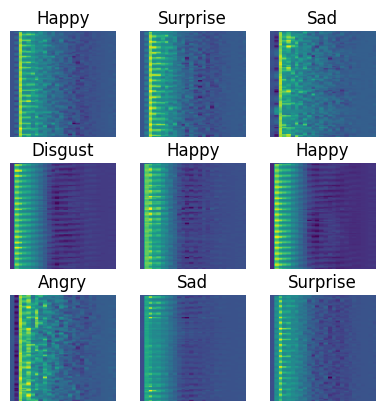

In [24]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_train[i])
    plt.title(f"{map_int_to_label(labels_train[i])}")  
    plt.axis("off")
plt.subplots_adjust(hspace=0.25)
plt.subplots_adjust(wspace=-0.45)
plt.show()

Prepare the val data for the CNN.

In [25]:
val_81k_folder = "val-81k"

In [26]:
# Load all MFCC images and file names. 
images_val = []
labels_val = []

image_filenames_val = os.listdir(MFCC_IMAGES_DIR / val_81k_folder)
image_paths_val = [os.path.join(MFCC_IMAGES_DIR / val_81k_folder, filename_val) for filename_val in image_filenames_val]

IMAGE_SIZE = (97,97)
N_CHANNELS = 1  # grey
for path_val in tqdm(image_paths_val): 
    file_name_val = os.path.basename(path_val)
    label_val = int(file_name_val.split(".")[0].split("_")[-1])    
    img_val = Image.open(path_val).convert("L")  # convert to greyscale
    img_val = img_val.resize(IMAGE_SIZE)
    img_array_val = np.array(img_val) / 255.0
    images_val.append(img_array_val)
    labels_val.append(label_val)

100%|█████████████████████████████████████| 2600/2600 [00:13<00:00, 197.84it/s]


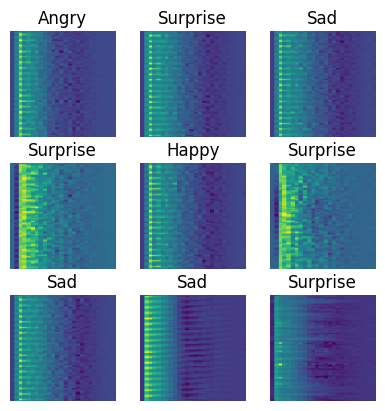

In [27]:
# plots inspired by https://www.kaggle.com/code/christianlillelund/classify-mnist-audio-using-spectrograms-keras-cnn
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_val[i])
    plt.title(f"{map_int_to_label(labels_val[i])}")  
    plt.axis("off")
plt.subplots_adjust(hspace=0.25)
plt.subplots_adjust(wspace=-0.45)

plt.show()

Create datasets and dataloaders.

In [28]:
images_train = torch.tensor(np.array(images_train), dtype=torch.float32)
images_train = images_train.unsqueeze(1)
labels_train = torch.tensor(np.array(labels_train), dtype=torch.long)
train81k_dataset = TensorDataset(images_train, labels_train)

images_val = torch.tensor(np.array(images_val), dtype=torch.float32)
images_val = images_val.unsqueeze(1)
labels_val = torch.tensor(np.array(labels_val), dtype=torch.long)
val81k_dataset = TensorDataset(images_val, labels_val)

In [29]:
batch_size = 32
train81k_loader = DataLoader(train81k_dataset, batch_size)
val81k_loader = DataLoader(val81k_dataset, batch_size)

#### Hyperparameter Optimization
Specify a study name and define the search space for the grid search. 

Run `PREPROCESSING: LOAD MFCC Images`.

In [42]:
import torch
import wandb
import math
import optuna
from optuna.trial import TrialState
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, precision_score, recall_score

Define the CNN model. Compute the hidden dimension of the transformed image successively. Images dimension are manipulated as follows:

1. Convolution layer: `output_dim` = `input_dim` - `filter_size` + `1`
2. Maxpool layer: `floor`((`input_dim`-`kernel_size`) / `stride`) + `1`

whereby the output dimension refers to either image height or image length. 

In [32]:
def define_model(trial):
    layers = []

    N_CLASSES = 6
    conv_kernel_size = trial.suggest_categorical(f"conv_kernel_size", [3, 5, 7])
    dropout_rate = trial.suggest_categorical("dropout_rate", [0.0, 0.1, 0.2])

    input_channels = 1
    out_channels_l1 = trial.suggest_categorical(f"out_channels_l1", [2 ** i for i in range(4, 8)])
    
    layers.append(torch.nn.Conv2d(input_channels, out_channels_l1, kernel_size=conv_kernel_size))
    hidden_img_height = IMAGE_SIZE[0] - conv_kernel_size + 1
    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))
    hidden_img_height = math.floor((hidden_img_height - 2) / 2) + 1
    layers.append(torch.nn.Dropout(dropout_rate))

    out_channels_l2 = trial.suggest_categorical(f"out_channels_l2", [2 ** i for i in range(4, 7)])

    layers.append(torch.nn.Conv2d(out_channels_l1, out_channels_l2, kernel_size=conv_kernel_size))
    hidden_img_height = hidden_img_height - conv_kernel_size + 1
    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))
    hidden_img_height = math.floor((hidden_img_height - 2) / 2) + 1
    layers.append(torch.nn.Dropout(dropout_rate))

    layers.append(torch.nn.Flatten())

    layers.append(torch.nn.Linear(out_channels_l2 * hidden_img_height * hidden_img_height, 64))  # Likely wrong...
    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Linear(64, N_CLASSES))

    config_dict = {
        "out_channels_l1": out_channels_l1,
        "out_channels_l2": out_channels_l2,
        "conv_kernel_size": conv_kernel_size,
        "dropout_rate": dropout_rate
    }

    return torch.nn.Sequential(*layers), config_dict

Define the objective function for optuna for the hyperparameter optimization.

In [33]:
def objective(trial): 
    model, config_dict = define_model(trial)

    lr = trial.suggest_categorical('lr', [0.0001, 0.001, 0.01])

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print(config_dict)
    name_experiment = (f"{trial.number}_{NAME_CORE}_lr-{lr}_convf1-{config_dict['out_channels_l1']}_convf2-"
                       f"{config_dict['out_channels_l2']}_convker-{config_dict['conv_kernel_size']}_dr-{config_dict['dropout_rate']}")

    config_dict["lr"] = lr
    config_dict["epochs"] = NUM_EPOCHS

    wandb.init(
        project="model_" + NAME_CORE + "-hpo",
        dir=LOGS_DIR,
        name=name_experiment,
        config=config_dict
    )


    for epoch in range(NUM_EPOCHS):
        model.train()
        for batch_data, batch_labels in tqdm(train81k_loader):          
            # zero gradients
            optimizer.zero_grad()

            # forward + backward pass
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

        all_preds = []
        all_labels = []

        model.eval()
        with torch.no_grad():
            for batch_data, batch_labels in tqdm(val81k_loader): 
                output = model(batch_data)

                predicted = output.argmax(dim=1)
                all_preds.extend(predicted.numpy())
                all_labels.extend(batch_labels.numpy())

        # TODO: explicitely state in written thesis that zero_division=0.0
        balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
        accuracy = accuracy_score(all_labels, all_preds)
        f1_class = f1_score(all_labels, all_preds, average=None, zero_division=0.0)
        f1_weighted = f1_score(all_labels, all_preds, average="weighted", zero_division=0.0)
        recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0.0)
        precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0.0)

        trial.report(balanced_accuracy, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

            
        metrics = {
            "balanced_accuracy": balanced_accuracy,
            "accuracy": accuracy,
            "f1_weighted": f1_weighted,
            "recall": recall,
            "precision": precision
        }

        wandb_input = metrics
        wandb.log(wandb_input)

    wandb.finish()

    return balanced_accuracy

Run hyperparameter optimization using optuna. 

In [51]:
NAME_CORE = "cnn_mfcc_6_grey_81k_searchspace_324"
NUM_EPOCHS = 20

In [48]:
search_space = {
    'lr': [0.0001, 0.001, 0.01],
    'out_channels_l1': [2 ** i for i in range(4, 8)],   # 4 values
    'out_channels_l2': [2 ** i for i in range(4, 7)],   # 3 values
    'conv_kernel_size': [3, 5, 7],
    "dropout_rate": [0.0, 0.1, 0.2]
}

In [37]:
num_combi = 1
for i in search_space:
    num_combi *= len(search_space[i])

In [38]:
sampler = optuna.samplers.GridSampler(search_space)
study = optuna.create_study(sampler=sampler, study_name=NAME_CORE, storage="sqlite:///hpo_" + NAME_CORE + ".db",
                            direction="maximize", load_if_exists=True)
study.optimize(objective, n_trials=num_combi)

[I 2024-01-06 16:01:31,569] A new study created in RDB with name: cnn_mfcc_6_grey_81k


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


wandb: Currently logged in as: totikos. Use `wandb login --relogin` to force relogin


100%|██████████████████████████████████████████| 82/82 [00:18<00:00,  4.33it/s]


accuracy,▁▆▆▇▇▇▇█████▇████▇▇█
balanced_accuracy,▁▆▆▇▇▇▆▇█▇▇▇▇▇▇▇▇███
f1_weighted,▁▆▆▇▇▇▇█████▇█▇▇█▇▇█
precision,▁▆▆▇▇▇▆████▇▇█▇▇▇▆▆▇
recall,▁▆▆▇▇▇▇█████▇████▇▇█
accuracy,0.54115
balanced_accuracy,0.37874
f1_weighted,0.52988
precision,0.51943
recall,0.54115


[I 2024-01-06 17:33:23,286] Trial 0 finished with value: 0.37873863016739945 and parameters: {'conv_kernel_size': 5, 'dropout_rate': 0.2, 'out_channels_l1': 64, 'out_channels_l2': 64, 'lr': 0.001}. Best is trial 0 with value: 0.37873863016739945.


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:06<00:00, 13.16it/s]


accuracy,▁▄▅▆▆▇▇▇▇███████▇▇▇█
balanced_accuracy,▁▆▆▇▇▇▇█████████▇▇██
f1_weighted,▁▄▄▆▇▇▇▇▇███████▇▇██
precision,▁▅▅▆▆▆▇▇▇███████▇▇▇█
recall,▁▄▅▆▆▇▇▇▇███████▇▇▇█
accuracy,0.54154
balanced_accuracy,0.37062
f1_weighted,0.52614
precision,0.52258
recall,0.54154


[I 2024-01-06 18:02:25,652] Trial 1 finished with value: 0.3706168997538896 and parameters: {'conv_kernel_size': 3, 'dropout_rate': 0.2, 'out_channels_l1': 16, 'out_channels_l2': 64, 'lr': 0.001}. Best is trial 0 with value: 0.37873863016739945.


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:28<00:00,  2.87it/s]


accuracy,▁▆▇▇▇▇████▇▇▇▇▇▆▆▆▆▆
balanced_accuracy,▁▅▇▇▇▇████▇▇▇▇▇▇▆▇▆▆
f1_weighted,▁▆▇▇▇▇█████▇▇▇▇▇▇▇▆▇
precision,▁▇▇▇▇██████▇▇▇▇▇▇▇▇▇
recall,▁▆▇▇▇▇████▇▇▇▇▇▆▆▆▆▆
accuracy,0.52038
balanced_accuracy,0.36102
f1_weighted,0.50867
precision,0.49925
recall,0.52038


[I 2024-01-06 19:51:48,813] Trial 2 finished with value: 0.3610243753967088 and parameters: {'conv_kernel_size': 5, 'dropout_rate': 0.0, 'out_channels_l1': 64, 'out_channels_l2': 32, 'lr': 0.001}. Best is trial 0 with value: 0.37873863016739945.


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:06<00:00, 12.56it/s]


accuracy,▁▄▆▇▇▇▇▇▇▇██████▇▇▇▇
balanced_accuracy,▁▃▅▇▇▇▇▇███████▇▇▇▇▆
f1_weighted,▁▅▆▇▇▇▇▇▇████████▇▇▇
precision,▁▆▇▇▇▇▇▇▇▇████████▇▇
recall,▁▄▆▇▇▇▇▇▇▇██████▇▇▇▇
accuracy,0.52269
balanced_accuracy,0.35823
f1_weighted,0.5121
precision,0.50964
recall,0.52269


[I 2024-01-06 20:32:09,053] Trial 3 finished with value: 0.35822702797759765 and parameters: {'conv_kernel_size': 3, 'dropout_rate': 0.1, 'out_channels_l1': 16, 'out_channels_l2': 64, 'lr': 0.001}. Best is trial 0 with value: 0.37873863016739945.


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:13<00:00,  5.94it/s]


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
balanced_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1_weighted,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.31731
balanced_accuracy,0.16667
f1_weighted,0.15286
precision,0.10068
recall,0.31731


[I 2024-01-06 21:34:38,881] Trial 4 finished with value: 0.16666666666666666 and parameters: {'conv_kernel_size': 5, 'dropout_rate': 0.0, 'out_channels_l1': 64, 'out_channels_l2': 32, 'lr': 0.01}. Best is trial 0 with value: 0.37873863016739945.


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:10<00:00,  7.88it/s]
[I 2024-01-06 21:36:51,936] Trial 5 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:08<00:00,  9.55it/s]
[I 2024-01-06 21:38:40,696] Trial 6 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:20<00:00,  4.07it/s]
[I 2024-01-06 21:43:08,106] Trial 7 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:11<00:00,  6.87it/s]


accuracy,▁▆▇▇▇███▇█▇▆▆▇▇▆▆▆▅▅
balanced_accuracy,▁▇▇▇▇█████▇▆▆▆▆▆▆▅▅▅
f1_weighted,▁▇▇▇▇███▇█▇▇▇▇▇▇▇▆▆▆
precision,▁▄▅▆▆▇██▆█▆▅▆▅▅▄▅▃▁▃
recall,▁▆▇▇▇███▇█▇▆▆▇▇▆▆▆▅▅
accuracy,0.50577
balanced_accuracy,0.35281
f1_weighted,0.50063
precision,0.49997
recall,0.50577


[I 2024-01-06 22:32:31,815] Trial 8 finished with value: 0.35280862958420806 and parameters: {'conv_kernel_size': 5, 'dropout_rate': 0.1, 'out_channels_l1': 32, 'out_channels_l2': 64, 'lr': 0.001}. Best is trial 0 with value: 0.37873863016739945.


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 15.62it/s]
[I 2024-01-06 22:33:47,644] Trial 9 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:10<00:00,  7.90it/s]
[I 2024-01-06 22:35:41,864] Trial 10 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:19<00:00,  4.14it/s]
[I 2024-01-06 22:40:06,816] Trial 11 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:19<00:00,  4.10it/s]
[I 2024-01-06 22:49:04,764] Trial 12 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.46423
balanced_accuracy,0.29992
f1_weighted,0.42457
precision,0.43232
recall,0.46423


100%|██████████████████████████████████████████| 82/82 [00:06<00:00, 12.24it/s]
[I 2024-01-06 22:50:30,687] Trial 13 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:17<00:00,  4.62it/s]
[I 2024-01-06 22:54:18,036] Trial 14 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:06<00:00, 13.19it/s]
[I 2024-01-06 22:55:39,481] Trial 15 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:06<00:00, 11.89it/s]
[I 2024-01-06 22:57:19,406] Trial 16 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 13.86it/s]
[I 2024-01-06 22:58:33,426] Trial 17 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.77it/s]
[I 2024-01-06 23:01:25,337] Trial 18 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.63it/s]
[I 2024-01-06 23:04:55,700] Trial 19 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 11.62it/s]
[I 2024-01-06 23:06:24,778] Trial 20 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:08<00:00,  9.22it/s]
[I 2024-01-06 23:08:19,735] Trial 21 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  9.01it/s]
[I 2024-01-06 23:10:00,321] Trial 22 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:17<00:00,  4.64it/s]


accuracy,▁▆▇▇▇██▇███▇▇▇▇▇▆▆▆▆
balanced_accuracy,▁▆▇▇▇█████▇▇▇▇▆▆▆▆▆▆
f1_weighted,▁▇▇▇▇█████████▇▇▇▇▇▇
precision,█▁▂▂▂▃▃▂▂▃▂▂▂▃▂▂▂▂▁▂
recall,▁▆▇▇▇██▇███▇▇▇▇▇▆▆▆▆
accuracy,0.51077
balanced_accuracy,0.35002
f1_weighted,0.49863
precision,0.49888
recall,0.51077


[I 2024-01-07 00:07:25,543] Trial 23 finished with value: 0.35001686698334367 and parameters: {'conv_kernel_size': 3, 'dropout_rate': 0.1, 'out_channels_l1': 64, 'out_channels_l2': 32, 'lr': 0.001}. Best is trial 0 with value: 0.37873863016739945.


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.41it/s]
[I 2024-01-07 00:09:08,838] Trial 24 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:06<00:00, 12.02it/s]
[I 2024-01-07 00:10:47,402] Trial 25 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:17<00:00,  4.82it/s]
[I 2024-01-07 00:22:14,363] Trial 26 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


accuracy,▁█
balanced_accuracy,▁█
f1_weighted,▁█
precision,▁█
recall,▁█
accuracy,0.51538
balanced_accuracy,0.35709
f1_weighted,0.49584
precision,0.49536
recall,0.51538


100%|██████████████████████████████████████████| 82/82 [00:18<00:00,  4.49it/s]
[I 2024-01-07 00:25:42,145] Trial 27 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.38it/s]
[I 2024-01-07 00:29:37,793] Trial 28 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.47154
balanced_accuracy,0.31599
f1_weighted,0.43454
precision,0.44188
recall,0.47154


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 16.08it/s]
[I 2024-01-07 00:30:50,527] Trial 29 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.45it/s]
[I 2024-01-07 00:32:55,184] Trial 30 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:13<00:00,  6.18it/s]
[I 2024-01-07 00:35:42,672] Trial 31 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:08<00:00,  9.60it/s]
[I 2024-01-07 00:37:41,787] Trial 32 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:11<00:00,  7.41it/s]
[I 2024-01-07 00:40:10,328] Trial 33 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 16.89it/s]
[I 2024-01-07 00:41:20,742] Trial 34 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:06<00:00, 12.38it/s]
[I 2024-01-07 00:46:08,132] Trial 35 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


accuracy,▁█
balanced_accuracy,▁█
f1_weighted,▁█
precision,▁█
recall,▁█
accuracy,0.51962
balanced_accuracy,0.34985
f1_weighted,0.50417
precision,0.50395
recall,0.51962


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.32it/s]
[I 2024-01-07 00:48:05,864] Trial 36 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:08<00:00,  9.37it/s]
[I 2024-01-07 00:49:57,147] Trial 37 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 19.05it/s]
[I 2024-01-07 00:52:01,685] Trial 38 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.42115
balanced_accuracy,0.2881
f1_weighted,0.37725
precision,0.41604
recall,0.42115


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.55it/s]
[I 2024-01-07 00:53:59,077] Trial 39 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:15<00:00,  5.25it/s]
[I 2024-01-07 00:57:27,787] Trial 40 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:13<00:00,  6.05it/s]
[I 2024-01-07 01:00:05,254] Trial 41 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 17.92it/s]
[I 2024-01-07 01:04:13,627] Trial 42 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


accuracy,▁▇█
balanced_accuracy,▁▆█
f1_weighted,▁▇█
precision,▁▆█
recall,▁▇█
accuracy,0.52462
balanced_accuracy,0.36694
f1_weighted,0.50426
precision,0.50002
recall,0.52462


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.70it/s]
[I 2024-01-07 01:06:18,487] Trial 43 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.55it/s]
[I 2024-01-07 01:14:54,917] Trial 44 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


accuracy,▁██
balanced_accuracy,▁██
f1_weighted,▁██
precision,▁██
recall,▁██
accuracy,0.52692
balanced_accuracy,0.36503
f1_weighted,0.50838
precision,0.50386
recall,0.52692


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.63it/s]
[I 2024-01-07 01:17:38,527] Trial 45 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.75it/s]
[I 2024-01-07 01:20:57,227] Trial 46 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:08<00:00, 10.06it/s]
[I 2024-01-07 01:22:45,777] Trial 47 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:10<00:00,  7.79it/s]
[I 2024-01-07 01:25:25,538] Trial 48 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:17<00:00,  4.68it/s]
[I 2024-01-07 01:29:13,735] Trial 49 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 14.75it/s]
[I 2024-01-07 01:30:25,464] Trial 50 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 14.19it/s]
[I 2024-01-07 01:32:59,089] Trial 51 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.47308
balanced_accuracy,0.31087
f1_weighted,0.42659
precision,0.45478
recall,0.47308


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.44it/s]
[I 2024-01-07 01:34:40,823] Trial 52 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:19<00:00,  4.12it/s]
[I 2024-01-07 01:38:33,997] Trial 53 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 17.16it/s]
[I 2024-01-07 01:39:39,818] Trial 54 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 13.75it/s]
[I 2024-01-07 01:40:58,247] Trial 55 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 18.25it/s]
[I 2024-01-07 01:41:54,135] Trial 56 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.97it/s]
[I 2024-01-07 01:43:23,401] Trial 57 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 18.72it/s]
[I 2024-01-07 01:44:23,070] Trial 58 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:10<00:00,  7.88it/s]
[I 2024-01-07 01:46:35,568] Trial 59 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 14.05it/s]
[I 2024-01-07 01:47:50,356] Trial 60 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.95it/s]
[I 2024-01-07 01:49:22,069] Trial 61 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 11.02it/s]
[I 2024-01-07 01:50:52,121] Trial 62 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:08<00:00,  9.76it/s]
[I 2024-01-07 01:52:45,190] Trial 63 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:15<00:00,  5.24it/s]
[I 2024-01-07 01:58:35,381] Trial 64 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.43808
balanced_accuracy,0.28817
f1_weighted,0.41789
precision,0.42969
recall,0.43808


100%|██████████████████████████████████████████| 82/82 [00:12<00:00,  6.32it/s]
[I 2024-01-07 02:01:17,522] Trial 65 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 18.65it/s]
[I 2024-01-07 02:02:20,556] Trial 66 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.47it/s]
[I 2024-01-07 02:05:32,351] Trial 67 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:06<00:00, 12.90it/s]
[I 2024-01-07 02:06:56,238] Trial 68 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:10<00:00,  8.01it/s]
[I 2024-01-07 02:09:12,463] Trial 69 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.58it/s]
[I 2024-01-07 02:12:12,976] Trial 70 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:15<00:00,  5.25it/s]
[I 2024-01-07 02:18:53,760] Trial 71 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.47
balanced_accuracy,0.31083
f1_weighted,0.42511
precision,0.4409
recall,0.47


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 17.20it/s]


accuracy,▁▆▇▇▇▇██▇▇▇▆▇▆▆▅▅▄▃▄
balanced_accuracy,▁▇██████▇▇▇▆▇▆▅▅▄▃▁▃
f1_weighted,▁▆▇▇████▇▇▇▆▇▆▆▅▅▄▄▃
precision,▃▅▆▆▇▇▇█▇▆▆▅▆▅▄▄▃▂▂▁
recall,▁▆▇▇▇▇██▇▇▇▆▇▆▆▅▅▄▃▄
accuracy,0.49769
balanced_accuracy,0.34526
f1_weighted,0.47561
precision,0.47379
recall,0.49769


[I 2024-01-07 02:38:54,268] Trial 72 finished with value: 0.34525809550793346 and parameters: {'conv_kernel_size': 5, 'dropout_rate': 0.0, 'out_channels_l1': 16, 'out_channels_l2': 32, 'lr': 0.001}. Best is trial 0 with value: 0.37873863016739945.


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.75it/s]
[I 2024-01-07 02:40:46,759] Trial 73 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:13<00:00,  6.03it/s]
[I 2024-01-07 02:43:22,073] Trial 74 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:13<00:00,  5.95it/s]
[I 2024-01-07 02:49:30,947] Trial 75 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.44538
balanced_accuracy,0.29394
f1_weighted,0.42845
precision,0.42387
recall,0.44538


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 20.10it/s]
[I 2024-01-07 02:50:26,667] Trial 76 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:10<00:00,  7.68it/s]
[I 2024-01-07 02:52:46,003] Trial 77 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:13<00:00,  6.26it/s]
[I 2024-01-07 02:55:39,906] Trial 78 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:10<00:00,  7.85it/s]
[I 2024-01-07 02:57:51,614] Trial 79 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.93it/s]
[I 2024-01-07 02:59:16,123] Trial 80 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 14.80it/s]
[I 2024-01-07 03:00:27,457] Trial 81 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:06<00:00, 13.56it/s]
[I 2024-01-07 03:01:46,722] Trial 82 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:13<00:00,  6.05it/s]
[I 2024-01-07 03:04:55,608] Trial 83 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 17.73it/s]
[I 2024-01-07 03:05:58,713] Trial 84 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 11.43it/s]
[I 2024-01-07 03:07:22,485] Trial 85 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:15<00:00,  5.18it/s]
[I 2024-01-07 03:11:12,995] Trial 86 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 18.31it/s]
[I 2024-01-07 03:12:12,926] Trial 87 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:17<00:00,  4.64it/s]


accuracy,▁▆▇█▇▇██▇▇▇██▇▇▇▇▇▇▇
balanced_accuracy,▁▇██▇▇███████▇▇▇▇▇▇▆
f1_weighted,▁▆▇█▇███▇▇▇██▇▇▇█▇▇▇
precision,▁▅▇█▇▇█▇▇▇▆█▇▆▇▇▇▆▆▆
recall,▁▆▇█▇▇██▇▇▇██▇▇▇▇▇▇▇
accuracy,0.53077
balanced_accuracy,0.36096
f1_weighted,0.5221
precision,0.52147
recall,0.53077


[I 2024-01-07 04:27:52,585] Trial 88 finished with value: 0.3609589025352144 and parameters: {'conv_kernel_size': 5, 'dropout_rate': 0.0, 'out_channels_l1': 64, 'out_channels_l2': 64, 'lr': 0.001}. Best is trial 0 with value: 0.37873863016739945.


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:16<00:00,  5.05it/s]
[I 2024-01-07 04:30:47,931] Trial 89 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:13<00:00,  6.24it/s]
[I 2024-01-07 04:33:09,277] Trial 90 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:06<00:00, 12.59it/s]
[I 2024-01-07 04:37:18,519] Trial 91 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


accuracy,▁█
balanced_accuracy,▁█
f1_weighted,▁█
precision,▁█
recall,▁█
accuracy,0.51731
balanced_accuracy,0.3643
f1_weighted,0.50454
precision,0.49358
recall,0.51731


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.78it/s]


accuracy,▁▇▅▇▇██▇█▇▇██▇█▇█▇▆▅
balanced_accuracy,▁▇▅▇▇▇█▇▇▇▆█▇▆███▇█▇
f1_weighted,▁▇▆▇▇████▇▇▇▇▆█▇█▇▆▅
precision,▁▆▅▆▇█▇▇█▇█▇▇▆▇▇▇▆▆▄
recall,▁▇▅▇▇██▇█▇▇██▇█▇█▇▆▅
accuracy,0.51885
balanced_accuracy,0.3701
f1_weighted,0.50494
precision,0.49993
recall,0.51885


[I 2024-01-07 05:23:36,293] Trial 92 finished with value: 0.3701021932210049 and parameters: {'conv_kernel_size': 5, 'dropout_rate': 0.2, 'out_channels_l1': 32, 'out_channels_l2': 64, 'lr': 0.001}. Best is trial 0 with value: 0.37873863016739945.


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.75it/s]
[I 2024-01-07 05:27:12,942] Trial 93 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.49615
balanced_accuracy,0.34792
f1_weighted,0.4617
precision,0.467
recall,0.49615


100%|██████████████████████████████████████████| 82/82 [00:16<00:00,  5.08it/s]
[I 2024-01-07 05:30:24,117] Trial 94 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.77it/s]
[I 2024-01-07 05:33:31,795] Trial 95 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:13<00:00,  6.21it/s]
[I 2024-01-07 05:36:02,368] Trial 96 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 19.02it/s]
[I 2024-01-07 05:37:02,702] Trial 97 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:06<00:00, 12.11it/s]
[I 2024-01-07 05:38:24,771] Trial 98 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.38it/s]
[I 2024-01-07 05:41:49,702] Trial 99 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.47154
balanced_accuracy,0.31717
f1_weighted,0.44082
precision,0.44011
recall,0.47154


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 17.90it/s]
[I 2024-01-07 05:42:43,759] Trial 100 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.89it/s]
[I 2024-01-07 05:44:13,923] Trial 101 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.69it/s]
[I 2024-01-07 05:45:59,862] Trial 102 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:17<00:00,  4.63it/s]
[I 2024-01-07 06:01:15,238] Trial 103 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


accuracy,▁▇█
balanced_accuracy,▁▇█
f1_weighted,▁▇█
precision,▁▇█
recall,▁▇█
accuracy,0.52
balanced_accuracy,0.36653
f1_weighted,0.49741
precision,0.49133
recall,0.52


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.74it/s]
[I 2024-01-07 06:02:59,412] Trial 104 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.65it/s]
[I 2024-01-07 06:04:48,190] Trial 105 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.97it/s]
[I 2024-01-07 06:06:22,148] Trial 106 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 18.29it/s]
[I 2024-01-07 06:08:04,652] Trial 107 pruned. 


Closer look into the trials. 

In [43]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

In [47]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of complete trials: ", len(complete_trials))
print("  Number of pruned trials: ", len(pruned_trials))

print("Best trial:")
trial_ = study.best_trial

print("  Value: ", trial_.value)
print("  Params: ")
for key, value in trial_.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  108
  Number of complete trials:  10
  Number of pruned trials:  98
Best trial:
  Value:  0.37873863016739945
  Params: 
    conv_kernel_size: 5
    dropout_rate: 0.2
    out_channels_l1: 64
    out_channels_l2: 64
    lr: 0.001


#### Training the CNN.
10 times training with best HP from HPO, and then average. 

#### Testing the Classifier

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

%run ../src/utils/constants.py

In [ ]:
test_81k_folder = "test-81k"

In [ ]:
# Load all MFCC images and file names. 
images_test = []
labels_test = []

image_filenames_test = os.listdir(MFCC_IMAGES_DIR / test_81k_folder)
image_paths_test = [os.path.join(MFCC_IMAGES_DIR / test_81k_folder, filename_test) for filename_test in image_filenames_test]

IMAGE_SIZE = (97,97)
N_CHANNELS = 1  # grey
for path_test in tqdm(image_paths_test): 
    file_name_test = os.path.basename(path_test)
    label_test = int(file_name_test.split(".")[0].split("_")[-1])    
    img_test = Image.open(path_test).convert("L")  # convert to greyscale
    img_test = img_test.resize(IMAGE_SIZE)
    img_array_test = np.array(img_test) / 255.0
    images_test.append(img_array_test)
    labels_test.append(label_test)

In [ ]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_test[i])
    plt.title(f"Label: {labels_test[i]}")   
    plt.axis("off")
plt.show()

In [ ]:
images_test = torch.tensor(np.array(images_test), dtype=torch.float32)
images_test = images_test.unsqueeze(1)
labels_test = torch.tensor(np.array(labels_test), dtype=torch.long)
test81k_dataset = TensorDataset(images_test, labels_test)

In [ ]:
batch_size = 32
test81k_loader = DataLoader(test81k_dataset, batch_size)